# Examples using 2 Lorentzians, instrument resolution and lmfit 

<a id='Table of Contents'></a><h1>Table of Contents</h1>
- <a href='#introduction'>Introduction</a>
- <a href='#imports'>Importing the required libraries</a>
- <a href='#ref_data'>Importing the reference data</a>
- <a href='#fitting'>Setting and fitting </a>  
- <a href='#plotting_results'>Plotting the results</a>  

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>
<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use one of the models of 
the <a href="https://github.com/QENSlibrary/QENSmodels">QENSlibrary</a>, <b>Lorentzian</b>, to perform some fits.
<a href="https://lmfit.github.io/lmfit-py/">lmfit</a> is used for fitting.
</div>

The following example uses the data from IRIS:
- workspace_index=0, file: `irs26176_graphite002_red.nxs` 
- related instrument resolution data `irs26173_graphite002_res.nxs` 

The ISIS sample datasets can be downloaded from [Mantid's website](http://download.mantidproject.org/).
The data used for this example are in the sample datafile: `data_2lorentzians.dat` and the instrument resolution datafile `irf_iris.dat`, respectively.

This example is based on a [Mantid "Fitting QENS Peaks" tutorial](https://www.mantidproject.org/Fitting_QENS_Peaks).

The implementation with `lmfit` is based on https://lmfit.github.io/lmfit-py/model.html

This example requires an additional Python module `scipy.interpolate` to interpolate the tabulated data of the instrument resolution

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2>Importing the required librairies</h2>

In [1]:
# install QENSmodels (if not already installed)
import sys
import pkgutil

if not pkgutil.find_loader("QENSmodels"):
    !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

In [2]:
# import python modules for plotting, fitting
from __future__ import print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# for interactive plot
import ipywidgets

# import model from QENS library
import QENSmodels

path_to_data = './data/'

In [3]:
# install lmfit (if not already installed)
if not pkgutil.find_loader("lmfit"):
    !{sys.executable} -m pip install lmfit
    
from lmfit import Model, CompositeModel
from scipy.interpolate import interp1d

(<a href='#Table of Contents'>Top</a>)<a id='ref_data'></a><h2>Importing the reference data</h2>

In [4]:
# Create model - 2 lorentzians convoluted with instrument resolution - 6 parameters
# Step 1 load instrument resolution data
irf_iris = np.loadtxt(path_to_data + 'irf_iris.dat')
x_irf = irf_iris[:, 0]
y_irf = irf_iris[:, 1]

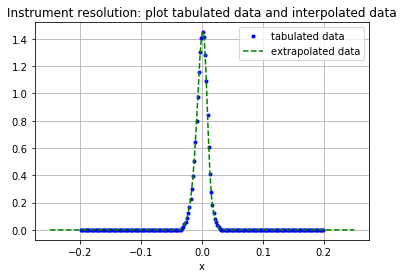

In [5]:
# Step 2: create function for instrument resolution data (cubic interpolation between tabulated data points)
f = interp1d(x_irf, y_irf, kind='cubic', bounds_error=False, fill_value='extrapolate')

def irf_gate(x):
    """ Function defined from the interpolation of instrument resolution data 
    Used to define fitting model and plot """ 
    return f(x)

# plot tabulated data and interpolated data
xx = np.linspace(-.25, .25, 500)
plt.plot(x_irf, y_irf, 'b.', label='tabulated data')
plt.plot(xx, irf_gate(xx), 'g--', label='extrapolated data')

plt.legend()
plt.xlabel('x')
plt.title('Instrument resolution: plot tabulated data and interpolated data')
plt.grid()
plt.show()

(<a href='#Table of Contents'>Top</a>)<a id='fitting'></a><h2>Setting and fitting</h2>

In [6]:
# Step 3: create "double lorentzian" profile
def model_2lorentzians(x, scale1, center1, hwhm1, scale2, center2, hwhm2):
    return QENSmodels.lorentzian(x, scale1, center1, hwhm1) + QENSmodels.lorentzian(x, scale2, center2, hwhm2)

In [7]:
# Step 4: create convolution function 
# code from https://lmfit.github.io/lmfit-py/model.html

def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

In [8]:
# Create model for the fit
gmodel = CompositeModel(Model(irf_gate), Model(model_2lorentzians), convolve) 

print('Names of parameters:', gmodel.param_names )
print('Independent variable(s):', gmodel.independent_vars )

Names of parameters: ['scale1', 'center1', 'hwhm1', 'scale2', 'center2', 'hwhm2']
Independent variable(s): ['x']


In [9]:
# Load reference data - extract x and y values
two_lorentzians_iris = np.loadtxt(path_to_data + 'data_2lorentzians.dat')
xx = two_lorentzians_iris[:, 0]
yy = two_lorentzians_iris[:, 1]

Text(0.5, 1.0, 'Plot before fitting: experimental data and mode with initial guesses')

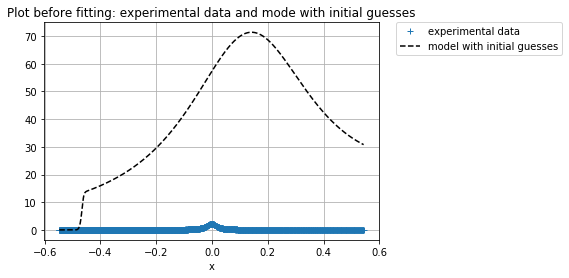

In [10]:
# Fit
result = gmodel.fit(yy, x=xx, scale1=1., center1=0., hwhm1=0.25, scale2=1., center2=1., hwhm2=0.25)
plt.plot(xx, yy, '+', label='experimental data')
plt.plot(xx, result.init_fit, 'k--', label='model with initial guesses')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.xlabel('x')
plt.title('Plot before fitting: experimental data and mode with initial guesses')

(<a href='#Table of Contents'>Top</a>)<a id='plotting_results'></a><h2>Plotting results </h2>

Result of fit:
 [[Model]]
    (Model(irf_gate) <function convolve at 0x11bf159d8> Model(model_2lorentzians))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 466
    # data points      = 1905
    # variables        = 6
    chi-square         = 0.68145667
    reduced chi-square = 3.5885e-04
    Akaike info crit   = -15105.6226
    Bayesian info crit = -15072.3092
[[Variables]]
    scale1:   0.00246457 +/- 4.7667e-06 (0.19%) (init = 1)
    center1: -0.12552370 +/- 3.3418e-05 (0.03%) (init = 0)
    hwhm1:    0.01640971 +/- 5.2959e-05 (0.32%) (init = 0.25)
    scale2:  -654.126542 +/- 95063843.9 (14532943.98%) (init = 1)
    center2: -19482.6114 +/- 17335450.8 (88979.09%) (init = 1)
    hwhm2:   -830.885218 +/- 1.2139e+08 (14609876.04%) (init = 0.25)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale2, hwhm2)   = -1.000
    C(scale1, hwhm1)   =  0.771
    C(scale2, center2) =  0.604
    C(center2, hwhm2)  = -0.596
    C(hwhm1, hwhm2)    =  0.145


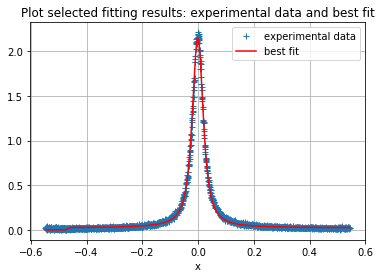

In [11]:
# display result
print('Result of fit:\n', result.fit_report())

# plot selected results: experimental data and best fit
plt.plot(xx, yy, '+', label='experimental data')

plt.plot(xx, result.best_fit, 'r-', label='best fit')
plt.grid()
plt.xlabel('x')
plt.title('Plot selected fitting results: experimental data and best fit')
plt.legend()
plt.show()

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

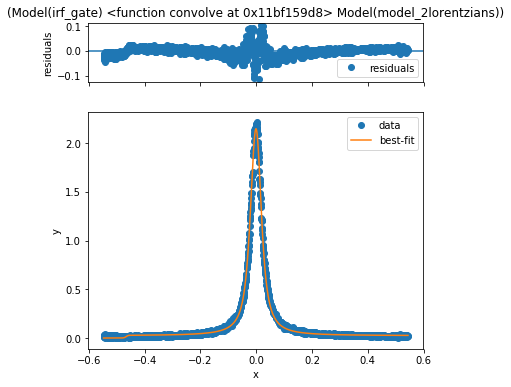

In [12]:
# other option to plot result using lmfit's features
result.plot()